In [ ]:
#Install the required libraries
!git lfs install
!pip install datasets
!pip install transformers

Git LFS initialized.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3


In [ ]:
#Import the required libraries
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datasets
from datasets import load_dataset,config
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
config.progress_bar_type = None

In [ ]:
#Load the ncbi dataset to fine tune the pre-trained model
med_dis = load_dataset("ncbi_disease")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

In [ ]:
#Exploring the dataset
#It consists of train,validation and test data
med_dis

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [ ]:
import pandas as pd
df_train=pd.DataFrame(med_dis["train"][:])
df_validation=pd.DataFrame(med_dis["validation"][:])
df_test=pd.DataFrame(med_dis["test"][:])

In [ ]:
df_new=pd.concat([df_train,df_validation,df_test])

**Pre-processing the data**

In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
import string
nltk.download('stopwords')

from nltk.corpus import stopwords

def preprocess(tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    # Remove punctuation and numbers and convert to lower
    tokens = [word.lower() for word in tokens if word not in string.punctuation and not word.isdigit()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens
df_new['cleaned_tokens'] = df_new['tokens'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**EDA on the cleaned tokens**

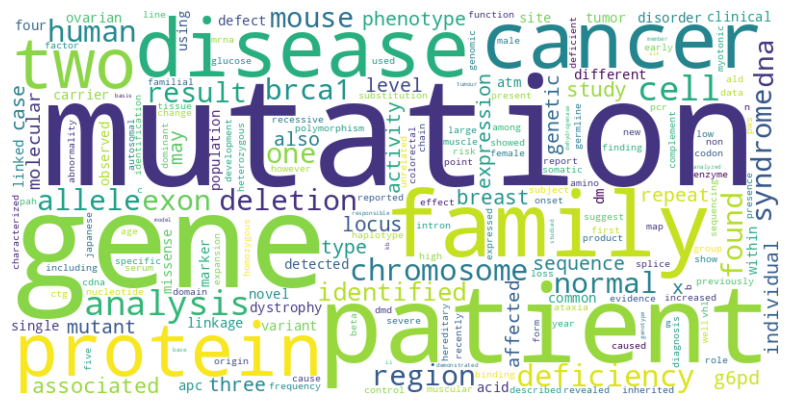

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
word_counts = Counter(word for tokens in df_new['cleaned_tokens'] for word in tokens)

# Create a word cloud based on word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The most commonly occuring words in the NCBI dataset are words such as mutation, disease,patient and gene.

In [ ]:
df_new

,id,tokens,ner_tags,cleaned_tokens
0,0,"[Identification, of, APC2, ,, a, homologue, of...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[identification, apc2, homologue, adenomatous,..."
1,1,"[The, adenomatous, polyposis, coli, (, APC, ),...","[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[adenomatous, polyposis, coli, apc, tumour, su..."
2,2,"[Complex, formation, induces, the, rapid, degr...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[complex, formation, induces, rapid, degradati..."
3,3,"[In, colon, carcinoma, cells, ,, loss, of, APC...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[colon, carcinoma, cell, loss, apc, lead, accu..."
4,4,"[Here, ,, we, report, the, identification, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[report, identification, genomic, structure, a..."
...,...,...,...,...
936,936,"[In, an, attempt, to, resolve, this, issue, ,,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[attempt, resolve, issue, comprehensively, cha..."
937,937,"[These, reagents, detect, a, 220, -, kD, prote...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[reagent, detect, kd, protein, localized, disc..."
938,938,"[Immunohistochemical, staining, of, human, bre...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[immunohistochemical, staining, human, breast,..."
939,939,"[Conversely, ,, BRCA1, expression, was, reduce...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[conversely, brca1, expression, reduced, undet..."


In [ ]:
flattened_tokens = [token for sublist in df_new["cleaned_tokens"] for token in sublist]

# Create a set from the flattened tokens to obtain unique tokens
vocab = set(flattened_tokens)

In [ ]:
vocab=list(vocab)

In [ ]:
len(vocab)

8370

In [ ]:
#Set of items present within the train dictionary
med_dis["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)}

In [ ]:
#Tags/labels defined in the ncbi datset to leverage ner
med_dis["train"].features["ner_tags"].feature.names

['O', 'B-Disease', 'I-Disease']

In [ ]:
#Tokenizing using the pre-tained model Biomed NLP from huggingface
tokenizer=AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [ ]:
#The first sentence in the train dataset
text_1=med_dis["train"][0]
print(text_1)

{'id': '0', 'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}


In [ ]:
tokenize_inp=tokenizer(text_1["tokens"],is_split_into_words=True)


In [ ]:
tokens=tokenizer.convert_ids_to_tokens(tokenize_inp["input_ids"])
word_ids=tokenize_inp.word_ids()

In [ ]:
tokenize_inp

{'input_ids': [2, 4824, 1927, 9187, 1028, 16, 43, 17986, 1927, 1920, 30390, 28641, 5178, 6383, 9241, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens #Why we recieved 17 tokens instead of 14

['[CLS]',
 'identification',
 'of',
 'apc',
 '##2',
 ',',
 'a',
 'homologue',
 'of',
 'the',
 'adenomatous',
 'polyposis',
 'coli',
 'tumour',
 'suppressor',
 '.',
 '[SEP]']

In [ ]:
word_ids

[None, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, None]

In [ ]:
#There is difference in tokens between the initial sentence and the once after applying tokenizer, hence they need more fine tuning
len(text_1["ner_tags"]),len(tokenize_inp["input_ids"])

(14, 17)

**Tokenizing based on pre-trained model**

In [ ]:
#Preprocessing tokenizing and allignment
"""This function is used to assign -100 to the special tokens and mask the subword that is a part
 of the previous subword.This process is done for the data to adapt with the tokenizer model"""
def tokenize_align(text_1,label_all_tokens=True):
  tokenize_inp=tokenizer(text_1["tokens"],truncation=True,is_split_into_words=True)
  tags=[]
  for id,tag in enumerate(text_1["ner_tags"]):
    word_ids=tokenize_inp.word_ids(batch_index=id)
    pre_word_id=None
    label_id=[]
    for word in word_ids:
      if word is None:
        label_id.append(-100)
      elif word!=pre_word_id:
        label_id.append(tag[word])
      else:
        label_id.append(tag[word] if label_all_tokens else -100)
      pre_word_id=word
    tags.append(label_id)
  tokenize_inp["tag"]=tags
  return tokenize_inp

In [ ]:
r=tokenize_align(med_dis["train"][0:2])
print(r)

{'input_ids': [[2, 4824, 1927, 9187, 1028, 16, 43, 17986, 1927, 1920, 30390, 28641, 5178, 6383, 9241, 18, 3], [2, 1920, 30390, 28641, 5178, 12, 9187, 13, 6383, 17, 9241, 2213, 3562, 1920, 7028, 8076, 3374, 2007, 7402, 43, 2796, 1956, 13302, 8921, 4016, 6341, 9215, 12, 9822, 17, 6341, 9215, 13, 16, 19911, 1022, 19, 7569, 1921, 1930, 4666, 11281, 7392, 18, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'tag': [[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, -100], [-100, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]]}
